<a href="https://colab.research.google.com/github/dhirajkrgupta/classical-models/blob/main/classicalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textstat
!pip install gdown  # only if not already installed


In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score,roc_curve,auc
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade
import json
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# **Step 1: Data Preparation**

In [ ]:
def load_and_prepare_data(json_file_path):
    """
    Load the dataset and create labels for human vs AI classification
    """
    data = []

    # Read the JSON dataset
    with open(json_file_path, 'r') as f:
        for line_num, line in enumerate(f, 1):
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Skipping line {line_num} due to JSONDecodeError: {e}")
                continue  # Skip to the next line if decoding fails
    #make a table from the data
    df = pd.DataFrame(data)

    # Create the classification dataset
    classification_data = []
    #iterate through each row of the table df
    for _, row in df.iterrows():
        # Human review (label = 1)
        human_review = row.get('full_human_review', '')
        if human_review and str(human_review).strip():  # Check if not empty
            classification_data.append({
                'text': str(human_review).strip(),
                'label': 1,  # Human = 1
                'source': 'human'
            })

        # AI/Machine review (label = 0)
        machine_review = row.get('machine_review', '')
        if machine_review and str(machine_review).strip():  # Check if not empty
            classification_data.append({
                'text': str(machine_review).strip(),
                'label': 0,  # AI = 0
                'source': 'ai'
            })

    return pd.DataFrame(classification_data)

# **Step 2: Feature Engineering**

In [ ]:
class ReviewFeatureExtractor:
    """
    Extract various features from review texts
    """

    def __init__(self):
        # Initialize sentiment analyzer
        nltk.download('vader_lexicon', quiet=True)
        self.sia = SentimentIntensityAnalyzer()

    def extract_linguistic_features(self, text):
        """Extract linguistic and stylistic features"""
        features = {}

        # Handle empty, None, or invalid text
        if not text or not isinstance(text, str) or pd.isna(text):
            text = ""

        text = str(text).strip()

        # Basic text statistics
        features['char_count'] = len(text)
        words = text.split() if text else []
        features['word_count'] = len(words)
        sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()] if text else []
        features['sentence_count'] = max(len(sentences), 1)
        features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
        features['avg_sentence_length'] = features['word_count'] / features['sentence_count']

        # Replace NaN values with 0
        if np.isnan(features['avg_word_length']):
            features['avg_word_length'] = 0

        # Readability scores (with error handling)
        try:
            if text and len(text) > 10:
                features['flesch_reading_ease'] = flesch_reading_ease(text)
                features['flesch_kincaid_grade'] = flesch_kincaid_grade(text)
            else:
                features['flesch_reading_ease'] = 0
                features['flesch_kincaid_grade'] = 0
        except:
            features['flesch_reading_ease'] = 0
            features['flesch_kincaid_grade'] = 0

        # Punctuation and formatting
        text_len = max(len(text), 1)
        features['exclamation_ratio'] = text.count('!') / text_len
        features['question_ratio'] = text.count('?') / text_len
        features['comma_ratio'] = text.count(',') / text_len
        features['bullet_points'] = text.count('*') + text.count('-')

        # Sentiment analysis
        try:
            if text:
                sentiment_scores = self.sia.polarity_scores(text)
                features['sentiment_pos'] = sentiment_scores['pos']
                features['sentiment_neg'] = sentiment_scores['neg']
                features['sentiment_neu'] = sentiment_scores['neu']
                features['sentiment_compound'] = sentiment_scores['compound']
            else:
                features['sentiment_pos'] = 0
                features['sentiment_neg'] = 0
                features['sentiment_neu'] = 0.5
                features['sentiment_compound'] = 0
        except:
            features['sentiment_pos'] = 0
            features['sentiment_neg'] = 0
            features['sentiment_neu'] = 0.5
            features['sentiment_compound'] = 0

        # Academic writing indicators
        if text:
            features['first_person_pronouns'] = len(re.findall(r'\b(I|me|my|we|us|our)\b', text, re.IGNORECASE))
            features['passive_voice_indicators'] = len(re.findall(r'\b(is|are|was|were|been|being)\s+\w+ed\b', text))
            features['academic_phrases'] = len(re.findall(r'\b(however|furthermore|moreover|therefore|consequently|nevertheless)\b', text, re.IGNORECASE))
        else:
            features['first_person_pronouns'] = 0
            features['passive_voice_indicators'] = 0
            features['academic_phrases'] = 0

        return features

    def extract_all_features(self, texts):
        """Extract features for all texts"""
        features_list = []
        for text in texts:
            try:
                features = self.extract_linguistic_features(str(text))
                features_list.append(features)
            except Exception as e:
                print(f"Error processing text: {e}")
                # Create default features in case of error
                features = {
                    'char_count': 0, 'word_count': 0, 'sentence_count': 1,
                    'avg_word_length': 0, 'avg_sentence_length': 0,
                    'flesch_reading_ease': 0, 'flesch_kincaid_grade': 0,
                    'exclamation_ratio': 0, 'question_ratio': 0, 'comma_ratio': 0,
                    'bullet_points': 0, 'sentiment_pos': 0, 'sentiment_neg': 0,
                    'sentiment_neu': 0, 'sentiment_compound': 0,
                    'first_person_pronouns': 0, 'passive_voice_indicators': 0,
                    'academic_phrases': 0
                }
                features_list.append(features)

        return pd.DataFrame(features_list)

# **Step 3: Text Vectorization**


In [ ]:
def create_text_features(texts, max_features=5000, ngram_range=(1, 2), vectorizer_type='tfidf'):
    """
    Create text features using different vectorization methods
    """
    # Clean and preprocess texts
    cleaned_texts = []
    for text in texts:
        if text and isinstance(text, str) and not pd.isna(text):
            cleaned_texts.append(str(text).strip())
        else:
            cleaned_texts.append("")

    # Choose vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )

    text_features = vectorizer.fit_transform(cleaned_texts)
    return text_features, vectorizer

# **Step 4: Model Training Pipeline**

In [ ]:
class FlexibleAIHumanClassifier:
    """
    Flexible classifier that can use any sklearn classifier
    """

    def __init__(self, classifier_name='logistic', max_features=3000, ngram_range=(1, 2),
                 vectorizer_type='tfidf', use_scaling=True):
        self.feature_extractor = ReviewFeatureExtractor()
        self.vectorizer = None
        self.scaler = StandardScaler() if use_scaling else None
        self.use_scaling = use_scaling
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer_type = vectorizer_type
        self.classifier_name = classifier_name

        # Initialize the classifier based on name
        self.model = self._get_classifier(classifier_name)
    def _get_classifier(self, classifier_name):
        """Get classifier by name with optimized parameters"""
        classifiers = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm': LinearSVC( C=1.0,max_iter=1000,tol=1e-3,dual=False,random_state=42),
            'naive_bayes': GaussianNB(),
            'knn': KNeighborsClassifier(n_neighbors=5),
            'decision_tree': DecisionTreeClassifier(random_state=42),
            'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'lda': LinearDiscriminantAnalysis(),
            'xgboost': XGBClassifier(random_state=42, n_jobs=-1),
            'mlp': MLPClassifier(random_state=42)
        }

        if classifier_name not in classifiers:
            raise ValueError(f"Classifier '{classifier_name}' not supported. Available: {list(classifiers.keys())}")

        return classifiers[classifier_name]

    def prepare_features(self, texts, fit_transform=True):
        """Prepare combined features (linguistic + text)"""
        # Extract linguistic features
        linguistic_features = self.feature_extractor.extract_all_features(texts)

        # Extract text features
        if fit_transform:
            text_features, self.vectorizer = create_text_features(
                texts, self.max_features, self.ngram_range, self.vectorizer_type
            )
        else:
            text_features = self.vectorizer.transform(texts)

        # Scale linguistic features if needed, but not for MultinomialNB
        if self.use_scaling and self.scaler and self.classifier_name != 'naive_bayes_multinomial':
            linguistic_features_scaled = self.scaler.fit_transform(linguistic_features.values) if fit_transform else self.scaler.transform(linguistic_features.values)
        else:
             linguistic_features_scaled = linguistic_features.values


        # Handle different classifiers that need dense vs sparse matrices
        if self.classifier_name == 'naive_bayes_multinomial':
            combined_features = text_features
        if self.classifier_name == 'svm_linear' and not self.use_scaling:
            # Keep everything sparse
            linguistic_sparse = sparse.csr_matrix(linguistic_features_scaled)
            combined_features = sparse.hstack([linguistic_sparse, text_features])
        else:
            # For classifiers that require dense input
            text_dense = text_features.toarray()
            combined_features = np.hstack([linguistic_features_scaled, text_dense])

        return combined_features

    def train(self, X_train, y_train):
        """Train the classifier"""
        # Prepare features
        X_train_features = self.prepare_features(X_train, fit_transform=True)

        # Train the model
        self.model.fit(X_train_features, y_train)
        return self

    def predict(self, X_test):
        """Make predictions"""
        # Prepare features
        X_test_features = self.prepare_features(X_test, fit_transform=False)

        # Predict
        predictions = self.model.predict(X_test_features)

        # Get probabilities if available
        try:
            probabilities = self.model.predict_proba(X_test_features)
        except:
            probabilities = None

        return predictions, probabilities

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        predictions, probabilities = self.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions, target_names=['AI', 'Human'])
        conf_matrix = confusion_matrix(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)

        # Calculate AUC if probabilities are available
        auc_score = None
        if probabilities is not None:
            auc_score = roc_auc_score(y_test, probabilities[:, 1])
            # Plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc="lower right")
            plt.show()

        return {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'predictions': predictions,
            'probabilities': probabilities
        }

# **Step 6: Usage Example**

In [ ]:
import gdown
file_id = "1a8NtVCapivEkETUMmJqIkoMsStGdHNCZ"
url = f"https://drive.google.com/uc?id={file_id}"
output = "subtaskC_train_dev.jsonl"  # local filename
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1a8NtVCapivEkETUMmJqIkoMsStGdHNCZ
To: /content/subtaskC_train_dev.jsonl
100%|██████████| 77.3M/77.3M [00:01<00:00, 55.5MB/s]


'subtaskC_train_dev.jsonl'

In [ ]:
def train_single_classifier(classifier_name='random_forest'):
    """
    Train a single classifier
    """
    # Load data
    df = load_and_prepare_data('/content/subtaskC_train_dev.jsonl')
    X = df['text'].values
    y = df['label'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier
    classifier = FlexibleAIHumanClassifier(classifier_name=classifier_name)
    classifier.train(X_train, y_train)

    # Evaluate
    results = classifier.evaluate(X_test, y_test)

    print(f"Results for {classifier_name}:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    if results['auc_score']:
        print(f"AUC Score: {results['auc_score']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(results['confusion_matrix'])
    print("\nClassification Report:")
    print(results['classification_report'])

    return classifier, results

**Logistic Regression**

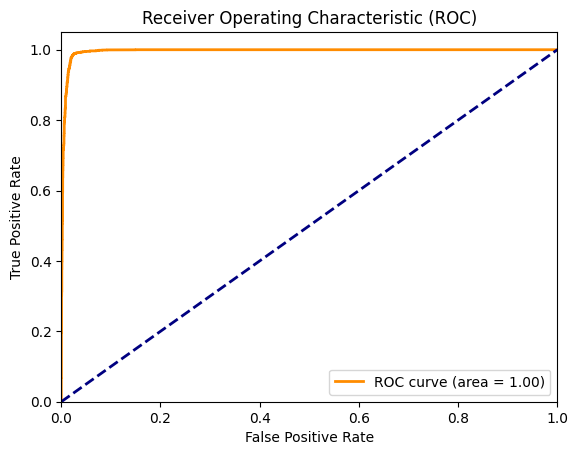

Results for logistic:
Accuracy: 0.9789
AUC Score: 0.9956
Precision: 0.9670
Recall: 0.9918
F1 Score: 0.9793

Confusion Matrix:
[[3744  132]
 [  32 3874]]

Classification Report:
              precision    recall  f1-score   support

          AI       0.99      0.97      0.98      3876
       Human       0.97      0.99      0.98      3906

    accuracy                           0.98      7782
   macro avg       0.98      0.98      0.98      7782
weighted avg       0.98      0.98      0.98      7782



In [ ]:
logistic,logistic_results= train_single_classifier(classifier_name='logistic');

**MLP**

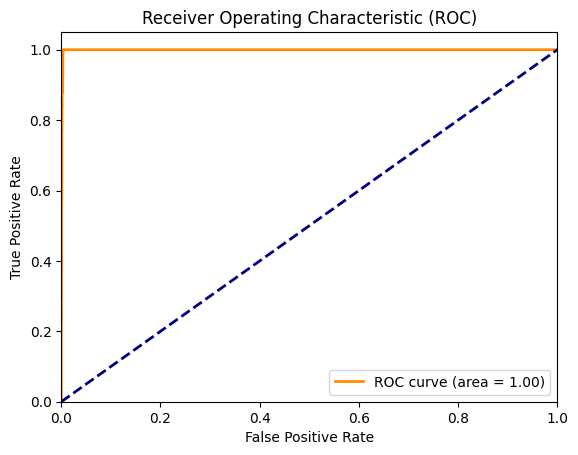

Results for mlp:
Accuracy: 0.9940
AUC Score: 0.9990
Precision: 0.9881
Recall: 1.0000
F1 Score: 0.9940

Confusion Matrix:
[[3829   47]
 [   0 3906]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      0.99      0.99      3876
       Human       0.99      1.00      0.99      3906

    accuracy                           0.99      7782
   macro avg       0.99      0.99      0.99      7782
weighted avg       0.99      0.99      0.99      7782



In [ ]:
mlp,mlp_results= train_single_classifier(classifier_name='mlp');

**Random forest**

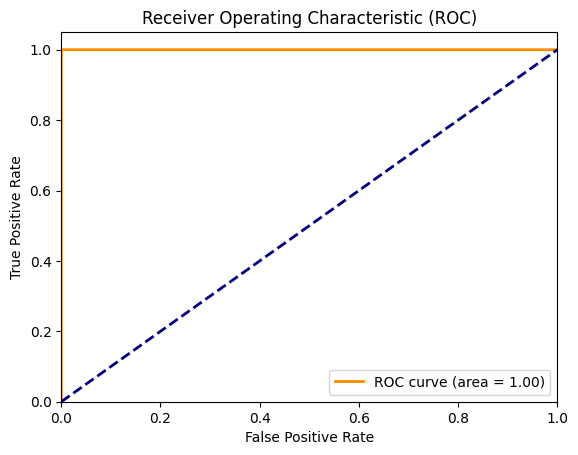

Results for random_forest:
Accuracy: 0.9985
AUC Score: 1.0000
Precision: 0.9969
Recall: 1.0000
F1 Score: 0.9985

Confusion Matrix:
[[3864   12]
 [   0 3906]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00      3876
       Human       1.00      1.00      1.00      3906

    accuracy                           1.00      7782
   macro avg       1.00      1.00      1.00      7782
weighted avg       1.00      1.00      1.00      7782



In [ ]:
random_forest,random_forest_results= train_single_classifier(classifier_name='random_forest');

**Naive Bayes**

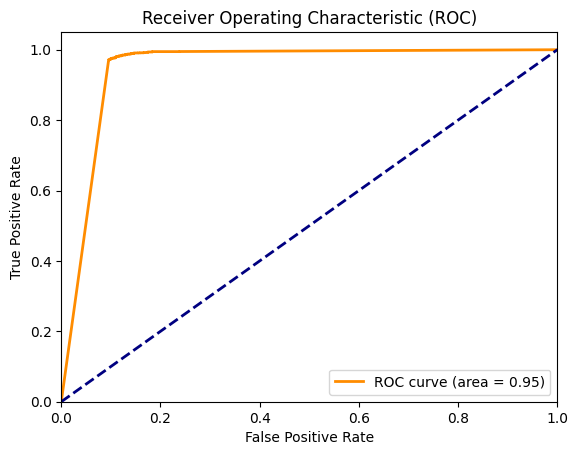

Results for naive_bayes:
Accuracy: 0.9373
AUC Score: 0.9474
Precision: 0.9073
Recall: 0.9747
F1 Score: 0.9398

Confusion Matrix:
[[3487  389]
 [  99 3807]]

Classification Report:
              precision    recall  f1-score   support

          AI       0.97      0.90      0.93      3876
       Human       0.91      0.97      0.94      3906

    accuracy                           0.94      7782
   macro avg       0.94      0.94      0.94      7782
weighted avg       0.94      0.94      0.94      7782



In [ ]:
classifier,results= train_single_classifier(classifier_name='naive_bayes')


KNN

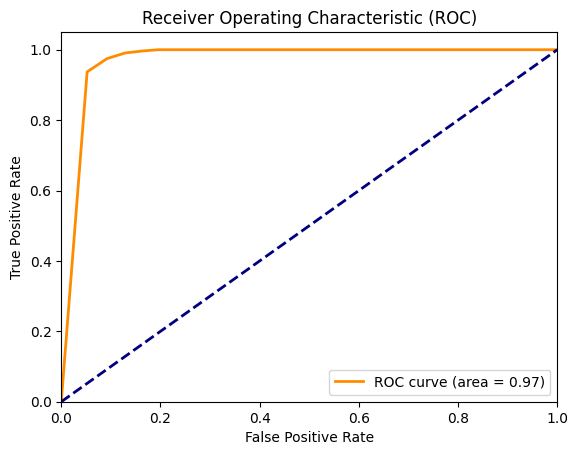

Results for knn:
Accuracy: 0.9313
AUC Score: 0.9696
Precision: 0.8858
Recall: 0.9908
F1 Score: 0.9353

Confusion Matrix:
[[3377  499]
 [  36 3870]]

Classification Report:
              precision    recall  f1-score   support

          AI       0.99      0.87      0.93      3876
       Human       0.89      0.99      0.94      3906

    accuracy                           0.93      7782
   macro avg       0.94      0.93      0.93      7782
weighted avg       0.94      0.93      0.93      7782



In [ ]:
knn,knn_results= train_single_classifier(classifier_name='knn')


**Decision Tree**

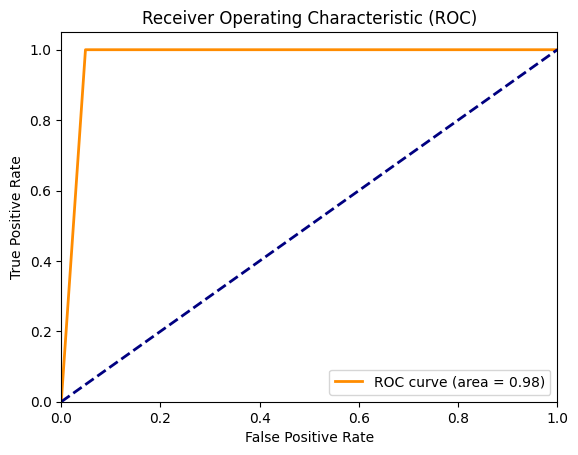

Results for decision_tree:
Accuracy: 0.9757
AUC Score: 0.9756
Precision: 0.9538
Recall: 1.0000
F1 Score: 0.9764

Confusion Matrix:
[[3687  189]
 [   0 3906]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      0.95      0.98      3876
       Human       0.95      1.00      0.98      3906

    accuracy                           0.98      7782
   macro avg       0.98      0.98      0.98      7782
weighted avg       0.98      0.98      0.98      7782



In [ ]:
decision_tree,decision_tree_results= train_single_classifier(classifier_name='decision_tree')


**Extra Trees**

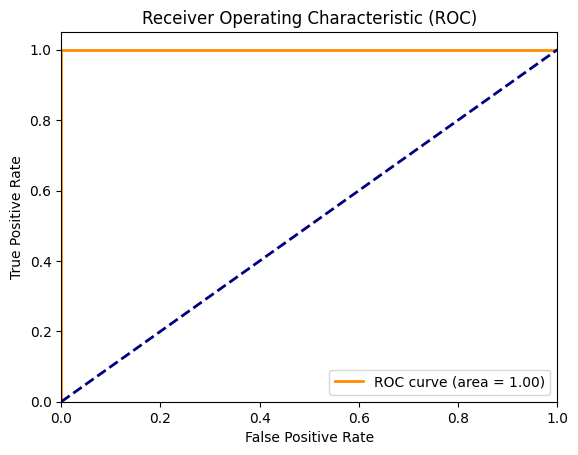

Results for extra_trees:
Accuracy: 0.9990
AUC Score: 1.0000
Precision: 0.9980
Recall: 1.0000
F1 Score: 0.9990

Confusion Matrix:
[[3868    8]
 [   0 3906]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00      3876
       Human       1.00      1.00      1.00      3906

    accuracy                           1.00      7782
   macro avg       1.00      1.00      1.00      7782
weighted avg       1.00      1.00      1.00      7782



In [ ]:
extra_trees,extra_trees_results= train_single_classifier(classifier_name='extra_trees')

**LDA**

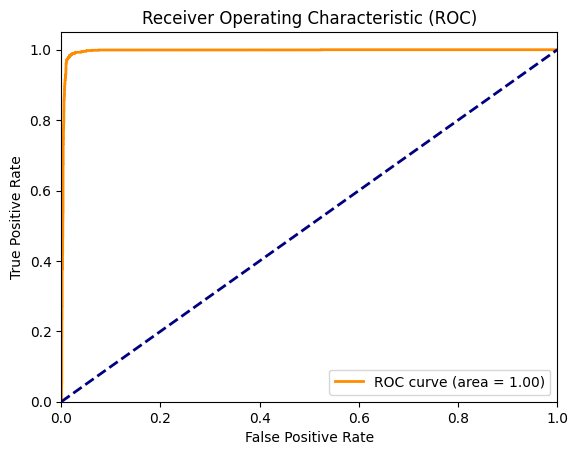

Results for lda:
Accuracy: 0.9767
AUC Score: 0.9958
Precision: 0.9611
Recall: 0.9939
F1 Score: 0.9772

Confusion Matrix:
[[3719  157]
 [  24 3882]]

Classification Report:
              precision    recall  f1-score   support

          AI       0.99      0.96      0.98      3876
       Human       0.96      0.99      0.98      3906

    accuracy                           0.98      7782
   macro avg       0.98      0.98      0.98      7782
weighted avg       0.98      0.98      0.98      7782



In [ ]:
lda,lda_results= train_single_classifier(classifier_name='lda')


**xgboost**

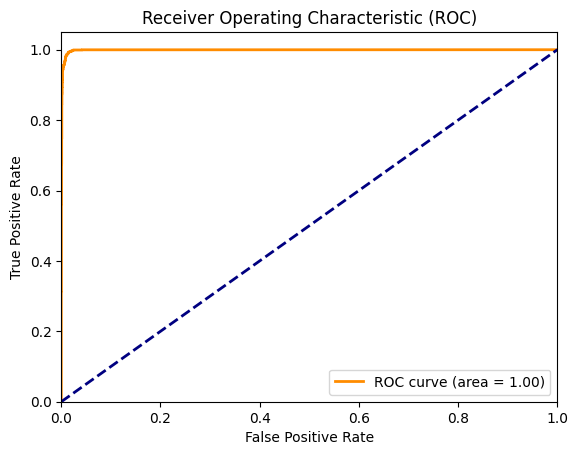

Results for xgboost:
Accuracy: 0.9875
AUC Score: 0.9990
Precision: 0.9779
Recall: 0.9977
F1 Score: 0.9877

Confusion Matrix:
[[3788   88]
 [   9 3897]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      0.98      0.99      3876
       Human       0.98      1.00      0.99      3906

    accuracy                           0.99      7782
   macro avg       0.99      0.99      0.99      7782
weighted avg       0.99      0.99      0.99      7782



In [ ]:
xgboost,xgboost_results= train_single_classifier(classifier_name='xgboost')


***SVM***

In [ ]:
svm,svm_results= train_single_classifier(classifier_name='svm')

Results for svm:
Accuracy: 0.9879
Precision: 0.9784
Recall: 0.9980
F1 Score: 0.9881

Confusion Matrix:
[[3790   86]
 [   8 3898]]

Classification Report:
              precision    recall  f1-score   support

          AI       1.00      0.98      0.99      3876
       Human       0.98      1.00      0.99      3906

    accuracy                           0.99      7782
   macro avg       0.99      0.99      0.99      7782
weighted avg       0.99      0.99      0.99      7782

